# Spielempfehlungen für Beispielnutzer

## Imports

In [1]:
%matplotlib inline
import sys 
sys.path
sys.path.append('./../')

from modules.utility import logStartOfScript, logWithTitle, printSeperator, cPrint, logCommaSeparatedList
from modules.create_model_functions import createFeaturesDataFrame, labelByPredefinedLists
from modules.transformers import transformDBResultForTraining, transformSimpleCategoricalDataForTraining, transformComplexCategoricalFeatureForTraining, getIndexesOfBetaTestGames, removeGamesFromFeaturesAndLabels, getOwnedGamesIndexes, removeGamesFromFeatures, getIndexesOfGamesMissingValue
from modules.model_metrics_helper_functions import logOverallPerformance, visualizeClassificationReport, visualizeClassImbalance, logNameOfPredictedGames, logCrossValidatedOverallPerformance, convertLabelToNumber, getGameRecommendations, getNameOfPredictedGames, visualizeLearningCurve, visualizeKFoldCrossValidation,visualizeFeatureImportance

from sklearn import svm, model_selection

import numpy
import pandas
#pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)
from joblib import dump
from sklearn.model_selection import GridSearchCV

## Raw Data - Game Meta Data & User Data

In [2]:
from sample_data.profile import user_profile_json as profile_response
from sample_data.games import games_json as games_response
from sample_data.boring_games import boring_games
from sample_data.interesting_games import interesting_games
from sample_data.top100In2Weeks_games import top100In2Weeks_games_json as top100In2Weeks_games

## Feature Selection

In [3]:
features_to_use = ["appid","name", "developer", "publisher"]

logWithTitle("USED-FEATURES")
logCommaSeparatedList(features_to_use[2:])
cPrint(str(len(features_to_use[2:])) + " Features in Use", "green")


------------- USED-FEATURES -----------
developer,publisher
2 Features in Use


## Transform Raw Data
Raw data is cleaned and being transformed into a format that is understandable by the classifier.

In [4]:
transformed_user_games = list(map(transformDBResultForTraining, games_response))
transformed_predictable_games = list(map(transformDBResultForTraining, top100In2Weeks_games))

## Prepare Predefined Labels For The Classifier
* The games have already been manually annotated. They've been labeled as **interesting** and **boring**.
* The labels will be put into a list, matching the games respective index inside the user_games_features  

In [5]:
labels = labelByPredefinedLists(transformed_user_games, boring_games, interesting_games)

there is no class defined for gameID: 497810
there is no class defined for gameID: 497811
there is no class defined for gameID: 431960
there is no class defined for gameID: 480430
there is no class defined for gameID: 427460
there is no class defined for gameID: 737010
there is no class defined for gameID: 654310
there is no class defined for gameID: 310950


## Convert To Pandas DataFrame
Data is being converted to a pandas dataFrame to visualize the data and make working with the dataset much easier.

In [6]:
user_games_features = createFeaturesDataFrame(transformed_user_games, features_to_use)
predictable_games_features = createFeaturesDataFrame(transformed_predictable_games, features_to_use)
user_games_features

,appid,name,developer,publisher
0,10,Counter-Strike,[Valve],Valve
1,80,Counter-Strike: Condition Zero,[Valve],Valve
2,100,Counter-Strike: Condition Zero,[Valve],Valve
3,240,Counter-Strike: Source,[Valve],Valve
4,3920,Sid Meier's Pirates!,[Firaxis Games],2K
5,4000,Garry's Mod,[Facepunch Studios],Valve
6,6200,Ghost Master,[Sick Puppies],Strategy First
7,4540,Titan Quest,[Iron Lore Entertainment],THQ Nordic
8,4550,Titan Quest: Immortal Throne,[Iron Lore Entertainment],THQ Nordic
9,475150,Titan Quest Anniversary Edition,"[Iron Lore Entertainment, THQ Nordic]",THQ Nordic


## Remove Irrelevant Games

In [7]:
logWithTitle("REMOVED GAMES")
print(len(user_games_features),len(labels))
irrelevant_games_indexes = getIndexesOfBetaTestGames(user_games_features)
relevant_games = removeGamesFromFeaturesAndLabels(irrelevant_games_indexes,user_games_features, labels)
user_games_features = relevant_games["features"]
labels = relevant_games["labels"]
print(len(user_games_features), len(labels))


------------- REMOVED GAMES -----------
535 535
Serious Sam Fusion 2017 (beta)
Arma 2: Operation Arrowhead Beta (Obsolete)
War of the Roses Balance Beta
Rust - Staging Branch
Magicka 2: Spell Balance Beta
CS:GO Player Profiles
CS:GO Player Profiles: n0thing - Cloud9
CS:GO Player Profiles:  TaZ - Virtus.Pro
CS:GO Player Profiles: GeT_RiGhT - Ninjas in Pyjamas
CS:GO Player Profiles: olofmeister - fnatic
CS:GO Player Profiles: kennyS - Team Envyus
CS:GO Player Profiles: Edward - Na'Vi
CS:GO Player Profiles: markeloff - Flipsid3
CS:GO Player Profiles: device - Team SoloMid
CS:GO Player Profiles: FalleN - Luminosity
CS:GO Player Profiles: karrigan - Astralis
CS:GO Player Profiles: pashaBiceps - Virtus.Pro
CS:GO Player Profiles: Guardian - Na'Vi
CS:GO Player Profiles: Happy - Team EnVyUs
CS:GO Player Profiles: fnx - Luminosity
CS:GO Player Profiles: Friberg - Ninjas in Pyjamas
CS:GO Player Profiles: Maikelele - FaZe
CS:GO Player Profiles: Fer - SK Gaming
CS:GO Player Profiles: Dupreeh - Ast

## Prepare DataFrame To Contain All Possible Feature Occurences
* all the users games and all potential predictable games are merged together into one dataframe
* converting all the categorical features (like genres or developers) into a sparse matrice
* merging all games together is neccessary because otherwise not all feature occurences would be represented in the sparse matrice
 

In [8]:
combined_games = pandas.concat([user_games_features, predictable_games_features])
combined_games = transformSimpleCategoricalDataForTraining(combined_games, ["publisher"])
combined_games = transformComplexCategoricalFeatureForTraining(combined_games, "developer")
#combined_games = transformComplexCategoricalFeatureForTraining(combined_games, "genres")
combined_games

,appid,name,publisher_,publisher_11 bit studios,publisher_17-BIT,publisher_1C Company,publisher_1C Entertainment,publisher_2K,publisher_2K Games,"publisher_2K, Aspyr (Mac)",...,developer_YAGER,developer_Young Horses,developer_Zen Studios,developer_Zero Point Software,developer_id Software,developer_inXile Entertainment,developer_inkle Ltd,developer_kChamp Games,developer_marbenx,developer_tinyBuild
0,10,Counter-Strike,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80,Counter-Strike: Condition Zero,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,100,Counter-Strike: Condition Zero,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,240,Counter-Strike: Source,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3920,Sid Meier's Pirates!,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4000,Garry's Mod,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6200,Ghost Master,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,4540,Titan Quest,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4550,Titan Quest: Immortal Throne,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,475150,Titan Quest Anniversary Edition,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split User Games And Predictable Games
User Games and potential predictable games need to be split apart again, because we only want to train and evaluate the classfier with real user data

In [9]:
END_INDEX_USER_GAMES = len(user_games_features)
START_INDEX_PREDICTABLE_GAMES = END_INDEX_USER_GAMES;
END_INDEX_PREDICTABLE_GAMES = len(user_games_features)+len(predictable_games_features)

user_games_features = combined_games.iloc[0:END_INDEX_USER_GAMES]
predictable_games_features = combined_games.iloc[START_INDEX_PREDICTABLE_GAMES:END_INDEX_PREDICTABLE_GAMES]

## Split Data Into Training and Test Dataset
* Using the stratified shuffle split, the data is divided into a trainingset and a testset.
* The "appid" and "name" column are being dropped to prevent the classifier from confusing these as features

In [10]:
sss = model_selection.StratifiedShuffleSplit(test_size=0.30)
user_games_features_named = user_games_features
for train_index, test_index in sss.split(user_games_features_named, labels):
    features_train_named, features_test_named = user_games_features_named.iloc[train_index], user_games_features_named.iloc[test_index]
    labels_train, labels_test = labels[train_index], labels[test_index]
features_train = features_train_named.drop(["appid","name"], axis=1)
features_test = features_test_named.drop(["appid","name"], axis=1)

logWithTitle("DATA SHAPES")
print(features_train.shape, labels_train.shape, " : ", features_test.shape, labels_test.shape)


------------- DATA SHAPES -----------
(349, 700) (349,)  :  (150, 700) (150,)


## Prepare Predictable Games

In [11]:
predictable_games_features_named = predictable_games_features
predictable_games_features = predictable_games_features.drop(["appid","name"], axis=1)

## Train Classifier

In [12]:
classifier = svm.SVC(kernel="rbf", gamma=1, C=100.0)
#classifier = svm.LinearSVC()

classifier.fit(features_train, list(map(convertLabelToNumber,labels_train)))
#classifier = classifier.best_estimator_
#dump(classifier,"trained_classifier.joblib")

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Visualize Performance


------------- CROSS VALIDATED METRICS -----------
INTERESTING RECALL
0.32
INTERESTING PRECISION
0.72
BORING RECALL
0.91
BORING PRECISION
0.7
ACCURACY
0.7
SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

------------- SINGLE RESULT PERFORMANCE -----------


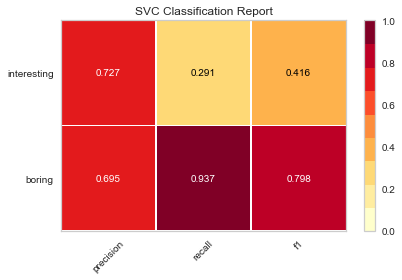


------------- CLASS BALANCE -----------
interesting: 183
boring: 316

------------- TRAIN CLASS BALANCE -----------
interesting: 128
boring: 221

------------- TEST CLASS BALANCE -----------
interesting: 55
boring: 95


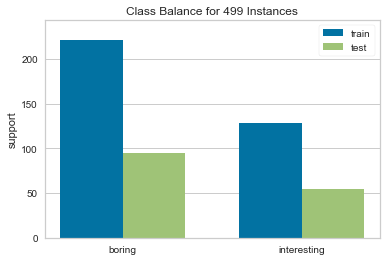


------------- LEARNING CURVE PRECISION -----------


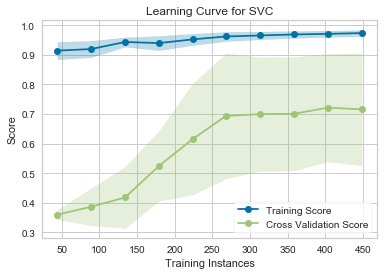


------------- LEARNING CURVE ACCURACY -----------


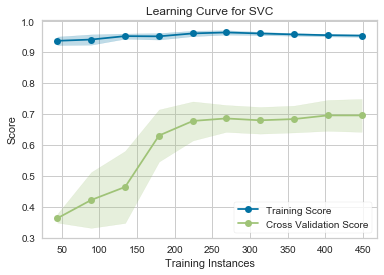

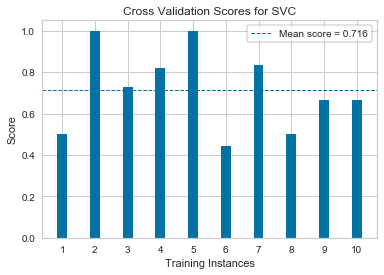

In [13]:
logCrossValidatedOverallPerformance(classifier, user_games_features.drop(["appid","name"], axis=1), labels)
print(classifier)
logWithTitle("SINGLE RESULT PERFORMANCE")
visualizeClassificationReport(classifier, features_train, labels_train, features_test, labels_test)
logWithTitle("CLASS BALANCE")
cPrint("interesting: " + str(len(list(filter(lambda prediction: prediction == "interesting", labels)))),color="green")
cPrint("boring: " + str(len(list(filter(lambda prediction: prediction == "boring", labels)))), color="red")
logWithTitle("TRAIN CLASS BALANCE")
cPrint("interesting: " + str(len(list(filter(lambda prediction: prediction == "interesting", labels_train)))),color="green")
cPrint("boring: " + str(len(list(filter(lambda prediction: prediction == "boring", labels_train)))), color="red")
logWithTitle("TEST CLASS BALANCE")
cPrint("interesting: " + str(len(list(filter(lambda prediction: prediction == "interesting", labels_test)))),color="green")
cPrint("boring: " + str(len(list(filter(lambda prediction: prediction == "boring", labels_test)))), color="red")
visualizeClassImbalance(labels_train, labels_test)
logWithTitle("LEARNING CURVE PRECISION")
visualizeLearningCurve(classifier, user_games_features, labels)
logWithTitle("LEARNING CURVE ACCURACY")
visualizeLearningCurve(classifier, user_games_features, labels, scoring='accuracy')
visualizeKFoldCrossValidation(classifier, user_games_features, labels)
#visualizeFeatureImportance(user_games_features, labels)





## Predict Test Set Games

In [14]:
predicted_labels = classifier.predict(features_test)
logNameOfPredictedGames(predicted_labels, features_test_named)

Sid Meier's Civilization IV
HELLDIVERS A New Hell Edition
Civilization IV: Beyond the Sword
Safety First!
SHOGUN: Total War - Collection
Crysis
Ultimate Chicken Horse
One Finger Death Punch
Eon Altar
Dead Island
Company of Heroes: Opposing Fronts
AdVenture Capitalist
GRID 2
Defense Technica
Lethal League
The Inner World
Sleeping Dogs
Tropico 5
Red Faction Guerrilla Re-Mars-tered
Portal
YOU DON'T KNOW JACK Vol. 2
Serious Sam HD: The First Encounter
Brothers - A Tale of Two Sons
Age of Empires II HD
Vertiginous Golf
Mother Russia Bleeds
Volleying
VVVVVV
Crazy Taxi
Lance A Lot: Enhanced Edition
Cockroach Simulator
Warframe
XCOM: Enemy Unknown
World of Guns: Gun Disassembly
Kane & Lynch 2: Dog Days
Confrontation
SteamWorld Dig
Shadow Warrior Classic Redux
Unturned
Surgeon Simulator
Yet Another Zombie Defense
No More Room in Hell
The Forest
Anachronox
Just Cause 3
BlazBlue: Chronophantasma Extend
Castle Crashers
Sonic Generations Collection
Warface
Risen 2: Dark Waters
Hitman 2: Silent Assa

## Predict Predictable Games

In [15]:
owned_games_indexes = getOwnedGamesIndexes(user_games_features_named,predictable_games_features_named)
print(owned_games_indexes)
print(len(predictable_games_features_named))
novelty_games = removeGamesFromFeatures(owned_games_indexes, predictable_games_features_named)
print("game not owned by user", len(novelty_games))
predicted_labels = classifier.predict(novelty_games.drop(["appid","name"], axis=1))
logWithTitle("PREDICTION RESULTS")
cPrint("interesting: " + str(len(list(filter(lambda prediction: prediction == "interesting", predicted_labels)))),color="green")
cPrint("boring: " + str(len(list(filter(lambda prediction: prediction == "boring", predicted_labels)))), color="red")
print("--------------")
#logNameOfPredictedGames(predicted_labels, novelty_games)
logWithTitle("3 FINAL RECOMMENDATIONS")
getGameRecommendations(predicted_labels, novelty_games)


[0, 7, 10, 15, 16, 20, 22, 24, 25, 26, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 71, 73, 74, 78, 79, 80, 81, 82, 84, 85, 88, 89, 90, 92, 94, 95, 97, 98]
100
game not owned by user 35

------------- PREDICTION RESULTS -----------
interesting: 20
boring: 15
--------------

------------- 3 FINAL RECOMMENDATIONS -----------


['Half-Life 2: Deathmatch', 'Half-Life 2', 'Alien Swarm']